<a href="https://colab.research.google.com/github/Kvnhooman/AAI520_Final-Project_Group5/blob/tommy-updated-text/Fina_Resear_Financial_AI_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Group 5

**AAI 520 - Final Project**

Authors: Kevin Hooman, Spencer Cody, Tommy Poole

Fall 2025



___
## Project Outline


This is an LLM powered research assistant that finds key financial details on publicly traded companies using their stock ticker. The assistant is able to plan and execute key tasks leveraging several tools in order to generate a final output.


**Core Agent Functions**


* Planning: The assistant has the ability to plan at each step.

* Tool Use: The assistant dynamically integrates APIs such as Yahoo Finance, SEC, as well as News APIs, we search APIs, and other tools.


* Self-Reflection: The assistnat has a specific agent focused on evaluation and output quality, including human in the loop feedback before concluding.


* Memory/Learning: The assistant also has memory to maintain context across runs.


**Workflow Patterns**
* Prompt Chaining: The agent dynamically follows a prompt chaining pattern between tool aclls including: News ingestion → preprocessing → classification → extraction → summarization


* Routing: The agent dynamically routes to specialist analyzers setup as tools to review earnings, draw graphs, and analyze market sentiment.


* Evaluator-Optimizer: The assistant ultimately performs an evaluation and optimizes the output incorporating human feedback.

#### Attribution:
This code leveraged several sources including.
1. LangGraph Intro to LangGraph course: https://academy.langchain.com/courses/take/intro-to-langgraph/
2. Hugging Face Course:https://huggingface.co/learn/agents-course/en/
3. Geek for Geeks Tutorial: https://www.geeksforgeeks.org/artificial-intelligence/introduction-to-langchain/
4. Perplexity AI for research and debugging. Accessed during October, 2025
5. Google Gemini within Colab for coding and debugging. Accessed during October, 2025

# Setup

The project incorporates several tools and libraries which are imported here.

In [1]:
%%capture --no-stderr
%pip install --quiet -U \
    langgraph \
    langchain_openai \
    langgraph_sdk \
    langgraph-prebuilt \
    langchain-perplexity \
    huggingface_hub \
    openai \
    yfinance \
    langchain-google-genai \
    langchain-community \
    transformers \
    datasets \
    bitsandbytes accelerate sentence-transformers \
    faiss-cpu \
    ddgs\
    langchain-huggingface\
    langchain-classic

In [2]:
#Import key libraries
import os
import requests
import re
import warnings
import textwrap
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint, pformat

from bs4 import BeautifulSoup

from langchain_core.tools import StructuredTool
from IPython.display import Markdown, display
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.chat_models import ChatPerplexity #updated
from langchain_openai import OpenAI, ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_classic.agents import  Tool, AgentExecutor, initialize_agent, AgentType
from langgraph.prebuilt import create_react_agent
import yfinance as yf
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from transformers import pipeline
from langchain_community.document_loaders import WebBaseLoader

#Memory
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List, Optional, Any, Union

For experimentation, multiple LLMs were included. The following APIs are required in the code:

1.   Gemini: https://ai.google.dev/
2.   Hugging Face: https://huggingface.co/
3.   OpenAI: https://openai.com/api/
4.   Fin News:https://finnhub.io/docs/api/market-news
5.   Tavily: https://www.tavily.com/



In [3]:
#Run in Google Colab
from google.colab import userdata

#API Keys from ColAb Secrets
gemini_key = userdata.get('GEMINI') #Used for agents in setup and validation
hf_key = userdata.get('HF_TOKEN') #Used for agents in setup and validation, also for sentiment analysis tool
openai_key = userdata.get('OPENAI')
fin_news = userdata.get('FIN_API_KEY') #For web search on financial news
tavily_key = userdata.get('TAVILY_API_KEY') #For web search


**Note:** We experimented with more APIs during the project, such as Perplexity, and others, but landed on this core set.

In [4]:
#Download and set up Hugging Face model
from huggingface_hub import login #Connect to HF using API key accessed above
login(token=hf_key)


#Suppress length warnings
warnings.filterwarnings("ignore", category=UserWarning, module="huggingface_hub.utils._auth")

llm_hf = pipeline(
    "text-generation",
    model="meta-llama/Llama-3.2-1B-Instruct",
    device= -1
    )

Device set to use cpu


In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain_huggingface import HuggingFacePipeline

model_id = "HuggingFaceTB/SmolLM2-1.7B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)

hf_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
    device=-1
)

llm_hf = HuggingFacePipeline(pipeline=hf_pipe)

Device set to use cpu


In [6]:
#Setup Gemini to use in Agents
llm_gemini = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=gemini_key
)

In [7]:
#Setup Open AI to use
llm_openai = ChatOpenAI(
    model="gpt-3.5-turbo",  # "gpt-3.5-turbo", "gpt-4-mini", "gpt-5-mini" ...
    openai_api_key=openai_key,  # Your OpenAI API key
    temperature=0.0             # (optional) set as needed
)

In [8]:
#Test APIs
print("OpenAI Response:")
response_openai = llm_openai.invoke("Explain how neural networks work in 10 words or less.")
print(response_openai.content)

print("\nGemini Response:")
response_gemini = llm_gemini.invoke("Explain how neural networks work in 10 words or less.")
print(response_gemini.content)

print("\nHugging Face Response:")
response_hf = llm_hf.invoke("Explain how neural networks work in 10 words or less.")
print(response_hf) # Keeping this as 'response_hf' for now to match the original print structure

OpenAI Response:
Neural networks learn patterns from data to make predictions.

Gemini Response:
Learn patterns from data, make predictions based on them.

Hugging Face Response:
Explain how neural networks work in 10 words or less.

Neural networks are artificial systems inspired by the human brain that process information by analyzing and adapting to patterns.


## Learning/Memory
Memory across analysis runs

In [9]:
#MEMORY AGENT
#Session-scoped memory

@dataclass
class MemoryItem:
    symbol: str
    question: str
    answer: str
    created_at: str
    meta: Dict[str, Any]

class SessionMemory:
    def __init__(self, max_items: int = 200, max_per_symbol: int = 10):
        self._store: Dict[str, List[MemoryItem]] = {}
        self.max_items = max_items
        self.max_per_symbol = max_per_symbol

    def remember(self, symbol: str, question: str, answer: str, **meta) -> None:
        symbol = (symbol or "GENERIC").upper().strip()
        item = MemoryItem(
            symbol=symbol,
            question=(question or "").strip(),
            answer=(answer or "").strip(),
            created_at=datetime.utcnow().isoformat(timespec="seconds"),
            meta=meta or {}
        )
        bucket = self._store.setdefault(symbol, [])
        bucket.append(item)
        if len(bucket) > self.max_per_symbol:
            del bucket[0 : len(bucket) - self.max_per_symbol]
        self._cap_global()

    def recall(self, symbol: str, question: Optional[str] = None) -> Optional[str]:
        symbol = (symbol or "GENERIC").upper().strip()
        bucket = self._store.get(symbol, [])
        if not bucket:
            return None
        if not question:
            return bucket[-1].answer
        q = (question or "").strip()
        for item in reversed(bucket):
            if item.question == q:
                return item.answer
        return None

    def latest(self, symbol: str) -> Optional[MemoryItem]:
        symbol = (symbol or "GENERIC").upper().strip()
        bucket = self._store.get(symbol, [])
        return bucket[-1] if bucket else None

    def _cap_global(self):
        all_items = []
        for sym, bucket in self._store.items():
            for it in bucket:
                all_items.append((it.created_at, sym, it))
        if len(all_items) <= self.max_items:
            return
        all_items.sort(key=lambda x: x[0])  #Oldest first
        to_drop = len(all_items) - self.max_items
        cutoff = set(id(it) for _, _, it in all_items[:to_drop])
        for sym in list(self._store.keys()):
            self._store[sym] = [it for it in self._store[sym] if id(it) not in cutoff]



def extract_symbol(text: str) -> str:
    """
    Grab a likely ticker from the user_input like 'Analyze the SPY stock ticker'.
    Simple heuristic: first ALL-CAPS token 1-5 chars (e.g., AAPL, MSFT, SPY).
    Falls back to 'GENERIC' if none found.
    """
    if not text:
        return "GENERIC"
    candidates = re.findall(r"\b[A-Z]{1,5}\b", text)
    #Light filter for common English words
    stop = {"THE","AND","FOR","WITH","FROM","THIS","THAT","YOUR","HAVE","HOLD"}
    for c in candidates:
        if c not in stop:
            return c
    return "GENERIC"

def as_text(x: Any) -> str:
    """
    Normalize whatever comes back from planner/tools/evaluator/optimizer into a string.
    Works with LangChain AgentExecutor outputs (dict), AIMessage, or raw str.
    """
    try:
        # AIMessage / ChatMessage
        if hasattr(x, "content"):
            return str(x.content)
        # Agent-like dicts
        if isinstance(x, dict):
            if "output" in x and isinstance(x["output"], str):
                return x["output"]
            if "messages" in x and isinstance(x["messages"], list):
                return "\n\n".join(
                    (m.content if hasattr(m, "content") else str(m))
                    for m in x["messages"]
                )
        # plain string
        if isinstance(x, str):
            return x
        return str(x)
    except Exception:
        return str(x)


def query_memory(stock_symbol, session_memory):
    print('query memory stock symbol = ', stock_symbol)
    if stock_symbol in session_memory._store:
        recent_memory = session_memory._store.get(stock_symbol)[-1].answer
        return recent_memory

In [10]:
SESSION_MEMORY = SessionMemory() #Create session memory for overall function

# Tool Agent

The tools agent performs the majority of the agent functions outlined for this project. By giving one agent access to these tools and specialists, it is able to plan, and dynamically select which tool is the best one to accomplish the goal.

This approach leverages the automony that agents can have to perform dynamic research tasks.

First the tools are defined, including testing/debugging code step by step.

## Tool Functions


In [11]:
#Yahoo Finance Tool
def get_stock_summary(ticker: str) -> str:

    """Gets detailed financial info for a given stock symbol."""

    try:
        stock = yf.Ticker(ticker) #Use teh defined stock ticker
        data = stock.info

        #Return as much data from the API as you can to fill in the report
        return (
            f"Company: {data.get('longName', 'N/A')} ({ticker})\n"
            f"Sector: {data.get('sector', 'N/A')}\n"
            f"Price: ${data.get('regularMarketPrice', 'N/A')}\n"
            f"Market Cap: {data.get('marketCap', 'N/A')}\n"
            f"P/E Ratio: {data.get('trailingPE', 'N/A')}\n"
            f"52-Week High: {data.get('fiftyTwoWeekHigh', 'N/A')}\n"
            f"52-Week Low: {data.get('fiftyTwoWeekLow', 'N/A')}\n"
            f"Dividend Yield: {data.get('dividendYield', 'N/A')}\n"
            f"Beta: {data.get('beta', 'N/A')}\n"
            f"Revenue: {data.get('totalRevenue', 'N/A')}\n"
            f"Profit Margin: {data.get('profitMargins', 'N/A')}\n"
        )
    except Exception as e:
        return f"Error retrieving data for {ticker}: {e}"

#Define the LangGraph tool
yahoo_api_tool = Tool(
    name="YahooFinanceAPI",
    func=get_stock_summary,
    description="Retrieves detailed Yahoo Finance company data such as price, valuation metrics, and financial ratios."
)

In [12]:
#For debugging
print(yahoo_api_tool.invoke("AAPL"))

Company: Apple Inc. (AAPL)
Sector: Technology
Price: $252.29
Market Cap: 3744081903616
P/E Ratio: 38.341946
52-Week High: 260.1
52-Week Low: 169.21
Dividend Yield: 0.41
Beta: 1.094
Revenue: 408624988160
Profit Margin: 0.24295999



In [13]:
import xml.etree.ElementTree as ET

#Define a summarizer for SEC content
def summarize_sec_document(doc_url: str) -> str:
    headers = {"User-Agent": "tpoole@sandiego.edu"}
    resp = requests.get(doc_url, headers=headers)
    if resp.status_code != 200:
        return f"Could not access doc: {doc_url}"
    doc_text = resp.text

    # Try XML parsing first (most filings)
    try:
        root = ET.fromstring(doc_text)
        values = []
        for item in root.iter():
            if item.tag.lower() in ['transactionamount', 'transactioncode', 'issuername']:
                values.append(f"{item.tag}: {item.text}")
        return " | ".join(values) if values else "No key XML findings found."
    except ET.ParseError:
        # Fallback: try HTML/text parsing
        soup = BeautifulSoup(doc_text, 'html.parser')
        summary = soup.get_text(separator=' ', strip=True)
        return summary[:400]  # Return first 400 chars as summary

def get_sec_filings(ticker: str) -> str:
    cik_url = "https://www.sec.gov/files/company_tickers.json"
    headers = {"User-Agent": "your_email@example.com"}
    cik_resp = requests.get(cik_url, headers=headers)
    if cik_resp.status_code != 200:
        return f"SEC.gov rejected request: {cik_resp.status_code}"

    try:
        cik_data = cik_resp.json()
        cik_lookup = {item['ticker']: item['cik_str'] for item in cik_data.values()}
        cik = cik_lookup.get(ticker.upper())
    except Exception as e:
        return f"Error parsing CIK data: {e}"

    if not cik:
        return f"CIK for {ticker} not found."

    filings_url = f"https://data.sec.gov/submissions/CIK{cik:0>10}.json"
    filings_resp = requests.get(filings_url, headers=headers)
    try:
        data = filings_resp.json() if filings_resp.status_code == 200 else {}
        filings = data.get('filings', {}).get('recent', {})
        if not filings: return f"No filings found for {ticker}."
        forms = filings.get('form', [])[:3]
        filing_dates = filings.get('filingDate', [])[:3]
        primary_docs = filings.get('primaryDocument', [])[:3]
        accessions = filings.get('accessionNumber', [])[:3]

        result = []
        for form, date, doc, acc in zip(forms, filing_dates, primary_docs, accessions):
            # Build the SEC document URL:
            doc_url = f"https://www.sec.gov/Archives/edgar/data/{int(cik)}/{acc.replace('-', '')}/{doc}"
            summary = summarize_sec_document(doc_url)
            result.append(f"{form} on {date}:\n{doc_url}\nSummary: {summary}\n")
        return "Latest filings with summaries:\n" + "\n".join(result)
    except Exception as e:
        return f"Error loading filings for {ticker}: {e}"

sec_api_tool = Tool(
    name="SECEDGARAPI",
    func=get_sec_filings,
    description="Retrieves and summarizes key findings from recent SEC filings by ticker"
)


In [14]:
#For debugging & Validation
print(sec_api_tool.invoke("AAPL"))

Latest filings with summaries:
4 on 2025-10-17:
https://www.sec.gov/Archives/edgar/data/320193/000205091225000008/xslF345X05/wk-form4_1760740266.xml
Summary: SEC FORM 
            4 SEC Form 4 FORM 4 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 STATEMENT OF CHANGES IN BENEFICIAL OWNERSHIP Filed pursuant to Section 16(a) of the Securities Exchange Act of 1934 or Section 30(h) of the Investment Company Act of 1940 OMB APPROVAL OMB Number: 3235-0287 Estimated average burden hours per response: 0.5 Â Â Check this box if no longer

4 on 2025-10-17:
https://www.sec.gov/Archives/edgar/data/320193/000163198225000009/xslF345X05/wk-form4_1760740212.xml
Summary: SEC FORM 
            4 SEC Form 4 FORM 4 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 STATEMENT OF CHANGES IN BENEFICIAL OWNERSHIP Filed pursuant to Section 16(a) of the Securities Exchange Act of 1934 or Section 30(h) of the Investment Company Act of 1940 OMB APPROVAL OMB Number: 323

In [15]:
#A tool to visit webpage to collect information
#This was built for the SEC, but they didn't like this web crawler, and did not permit it

STOCK_SITES = {
    "tipranks": "https://www.tipranks.com/stocks/{ticker}/stock-analysis",
    "marketbeat": "https://www.marketbeat.com/stocks/{ticker}/",
    "zacks": "https://www.zacks.com/stock/quote/{ticker}",
    "simplywallst": "https://simplywall.st/stocks/us/{ticker}"
}

def visit_webpages_for_symbol(ticker: str) -> dict:
    """
    Fetches and reads webpage information for a given stock ticker from all defined sites.
    Returns a dictionary with site names as keys and page content as values.
    """
    results = {}
    for site, url_pattern in STOCK_SITES.items():
        try:
            url = url_pattern.format(ticker=ticker)
            loader = WebBaseLoader(web_path=url)
            documents = loader.load()
            results[site] = documents[0].page_content[:1000]
        except Exception as e:
            results[site] = f"Error fetching {url}: {e}"
    return results

# Define the tool for agent use
visit_webpages_tool = StructuredTool.from_function(
    func=visit_webpages_for_symbol,
    name="VisitWebpagesForSymbol",
    description="Fetches and reads webpage information for a given stock ticker from all major analysis sites."
)

In [16]:
#Print for debug
result = visit_webpages_tool.invoke({"ticker": "AAPL"})
pretty_str = pformat(result, width=100)
lines = pretty_str.split('\n')
for line in lines[:25]:
    print(line)

{'marketbeat': '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\r\n'
               '\tStock Lists | Top Stocks by Interest, Sector, Exchange and More\r\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'
               '\n'


In [17]:
#Finanical news lookup
def get_fin_news(symbol: str) -> str:
    api_key = fin_news
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": symbol,
        "apiKey": api_key,
        "sortBy": "publishedAt",
        "language": "en"
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return f"API error {response.status_code}: {response.text[:200]}"
    data = response.json() #Return data in JSON
    articles = data.get("articles", [])
    if not articles:
        return f"No news found for {symbol}. Full message: {data.get('message', '')}"
    return "\n".join([a["description"] or a["title"] for a in articles[:7]])


#Define tool
news_api_tool = Tool(
    name="NewsAPI",
    func=get_fin_news,  #Assumes you've defined this class
    description="Finds recent financial news on stock symbol"
)

In [18]:
#For debugging
print(news_api_tool.invoke("AAPL"))

Requests from Big Tech for power supply are skyrocketing. If that demand doesn't end up following through, utility companies could be stuck with the bill.
I’m regularly struck by something American investors always seem to take for granted: The many choices we have available to gain financial independence.
Apple (AAPL) and Formula 1 announced a five-year partnership that will bring all F1 races exclusively to Apple TV in the United States beginning next year. “The partnership builds on Apple’s deepening relationship with Formula 1 following the global success o…
​​"Magnificent Seven" stocks are Apple (AAPL), Microsoft (MSFT), Alphabet (GOOGL), Amazon (AMZN), Meta Platforms (META), Nvidia (NVDA), and Tesla (TSLA).
With the end of the year in sight, and tech stocks having driven the markets sharply higher this year, talk of a potential bubble on Wall Street is growing, ...
Apple Inc. (NASDAQ:AAPL) is among the 14 Best Big Name Stocks to Invest in Right Now. On October 16, Evercore ISI ma

In [19]:
#Web search tool with Tavily
def get_fin_news_tavily(symbol: str) -> str:
    """
    Searches for and extracts news impacting the given stock symbol.
    Performs a deep extraction with Tavily's advanced read (HTML parsing and markdown conversion).
    """
    query = f"News on {symbol}"
    api_url_search = "https://api.tavily.com/search"
    api_url_extract = "https://api.tavily.com/extract" #Added to try and get better content

    #Search for related news articles
    payload_search = {
        "query": query,
        "api_key": tavily_key,
        "max_results": 15, #Increased up from 5 for final runs
        "search_depth": "advanced",#Search for more contextually relevant pages
        "include_raw_content": False
    }

    search_response = requests.post(api_url_search, json=payload_search)
    if search_response.status_code != 200:
        return f"Tavily search error: {search_response.status_code} {search_response.text}"

    results = search_response.json().get("results", [])
    links = [r.get("link") for r in results if r.get("link")]

    #Extract full article contents using Tavily Extract API
    if not links:
        return "No articles found for this stock symbol."

    payload_extract = {
        "urls": links,
        "api_key": tavily_key,
        "extract_depth": "advanced", #Deeper DOM parsing, better for long articles
        "include_images": False,
        "format": "markdown" #Returns Markdown-formatted summaries
    }

    extract_response = requests.post(api_url_extract, json=payload_extract)
    if extract_response.status_code != 200:
        return f"Tavily extract error: {extract_response.status_code} {extract_response.text}"

    extracted_articles = extract_response.json().get("results", [])
    if not extracted_articles:
        return "No extractable content retrieved."

    #Structure extracted results for downstream summarization or agent reflection
    summaries = [] #Instantiate blank list
    for article in extracted_articles: #Add to list
        link = article.get("url", "")
        content = article.get("content", "No text content")
        summaries

#Define Tool
tavily_news_tool = Tool(
    name="TavilyNews",
    func=get_fin_news_tavily,
    description="Searches for and extracts detailed financial news impacting the given stock symbol."
)


In [20]:
#For debugging
print(tavily_news_tool.invoke("META"))

No articles found for this stock symbol.


In [21]:
from langchain_core.tools import tool
#Create the pipeline once, outside the function for efficiency
sentiment_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

@tool
def analyze_sentiment(text: str) -> int:
    """Analyzes sentiment using DistilBERT."""
    result = sentiment_classifier(text)[0]
    return 1 if result["label"].upper() == "POSITIVE" else -1

Device set to use cpu


In [22]:
# Example usage:
print(analyze_sentiment.invoke({"text": "I love this product!"}))

1


In [23]:
def earnings_analyzer(symbol: str, context: str = "", yahoo_tool=None, sec_tool=None) -> str:
    # Use dummy data if no tool is provided
    yahoo_data = yahoo_tool if yahoo_tool else yahoo_dummy
    sec_data = sec_tool if sec_tool else sec_dummy

    # Example analysis logic
    analysis = (
        f"Earnings Analysis for {symbol}:\n"
        f"Yahoo Finance: {yahoo_data['summary']}\n"
        f"SEC Filing: {sec_data['filing_text']}\n"
    )
    return analysis

#Define tool
earnings_specialist = Tool(
    name="EarningsAnalyzer",
    func=earnings_analyzer,
    description="Analyzes earnings context and info for a stock symbol, using memory/context and sources."
)

In [24]:
#For debugging, supplied inputs for earnings specialist

yahoo_dummy = {
    "symbol": "AAPL",
    "earnings": {
        "quarter": "Q3 2025",
        "eps_actual": 2.15,
        "eps_estimate": 2.10,
        "revenue_actual": 82000000000,
        "revenue_estimate": 81500000000,
        "surprise": 0.05,
        "date": "2025-07-28"
    },
    "summary": "Apple reported better-than-expected earnings for Q3 2025, beating analyst estimates on both EPS and revenue."
}

sec_dummy = {
    "symbol": "AAPL",
    "filing_type": "10-Q",
    "filing_date": "2025-07-28",
    "filing_text": (
        "Apple Inc. reported net sales of $82 billion for the quarter ended June 2025, "
        "with net income of $19 billion. The company highlighted strong performance in its services segment."
    )
}

print(earnings_analyzer("META"))

Earnings Analysis for META:
Yahoo Finance: Apple reported better-than-expected earnings for Q3 2025, beating analyst estimates on both EPS and revenue.
SEC Filing: Apple Inc. reported net sales of $82 billion for the quarter ended June 2025, with net income of $19 billion. The company highlighted strong performance in its services segment.



In [25]:
#Add Duck Duck Go
from langchain_community.tools import DuckDuckGoSearchRun
search = DuckDuckGoSearchRun()

duck_duck_go_search = Tool(
    name="DuckDuckGoSearch",
    func=search.invoke,
    description="Useful for when you need to answer questions about stocks and current events."
)

In [26]:
duck_duck_go_search.invoke('What is the latest news on stock symbol GOOG')

"Find the latest Alphabet Inc. (GOOG) stock quote, history, news and other vital information to help you with your stock trading and investing. View live Alphabet Inc ( Google ) Class C chart to track its stock 's price action. Find market predictions, GOOG financials and market news . (Click here to get the latest quotes for Google .) Find information about the Alphabet Inc. stock (GOOGL). You can find more details by going to one of the sections under this page such as historical data, charts, technical analysis and others. NASDAQ. Symbol . Exchange.Summarize GOOGL's latest news . Latest News . Info icon.Your symbols have been updated. You'll now be able to see real-time price and activity for your symbols on the My Quotes of Nasdaq.com."

In [27]:
#Define the plotting function
def plot_stock_52_week(symbol: str) -> str:
    """
    Plots the last 52 weeks (1 year) of stock closing prices for the given symbol.
    Returns the filepath to the saved chart image.
    """
    try:
        end_date = datetime.today()
        start_date = end_date - timedelta(weeks=52)

        # Download 1-year historical stock data
        data = yf.download(symbol, start=start_date, end=end_date)

        if data.empty:
            return f"No data found for {symbol}. Please check the symbol or try again later."

        # Plot closing price over time
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data['Close'], label='Closing Price', color='dodgerblue', linewidth=2)
        plt.title(f"{symbol} Stock Price (Last 52 Weeks)", fontsize=14, pad=15)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price (USD)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()

        # Save plot to file
        filename = f"{symbol}_52week_chart.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

        return f"Stock chart saved as {filename}"
    except Exception as e:
        return f"Error generating chart for {symbol}: {e}"

#Wrap as a LangGraph Tool
stock_chart_tool = Tool(
    name="StockChart52Weeks",
    func=plot_stock_52_week,
    description="Plots and saves a 52-week stock price chart for the given symbol using Yahoo Finance data."
)


In [28]:
from datetime import datetime, timezone

def get_timestamp(_: str = "") -> str:
    """
    Returns the current date and time in ISO 8601 format.

    This tool can be used by the agent to log events, timestamp analyses,
    or align data with real-world time context. It supports chaining with
    other workflow nodes that require temporal awareness.
    """
    return datetime.now(timezone.utc).isoformat()

timestamp_tool = Tool(
    name="TimestampTool",
    func=get_timestamp,
    description="Returns the current date and time in ISO 8601 format, useful for logging or aligning time-based analyses."
)

In [29]:
print(get_timestamp())

2025-10-19T22:58:41.574513+00:00


In [30]:
#Create the tools list
tools = [
    yahoo_api_tool,
    sec_api_tool,
    news_api_tool,
    tavily_news_tool,
    earnings_specialist,
    duck_duck_go_search,
    stock_chart_tool,
    analyze_sentiment,  # Use the analyze_sentiment function here
    timestamp_tool,
    visit_webpages_tool
]

## Define Tools Agent

**Note:** This agent leverages the LangGraph ReAct agent framework. The basis of this agent is an LLM that is prompted to reason about what it should do, take an action, and then observe the results to evaluate if it should act again, or be done. In addition to that basic framework, the prompt contains critical functions and workflows for the agent to perform.

This prompt engineering is a balance to get a thorough enough agent to select multiple tools, while not creating an agent that is either too lazy, quitting with too few API calls, or too aggresive.

In [31]:
#Tools Agent Prompt & Function

ANALYSIS_PROMPT = """
System Role: You are a detailed Financial Research Agent designed to analyze companies, securities, and markets with a structured workflow.

**Your goal** For {symbol}, provide a ~50 word investment summary, based on extensive reserach.

Include {context_memory} to improve your answers.

NEVER INCLUDE YOUR THOUGHT PROCESS IN THE RESULTS.


**Core Functions**

1. Planning:
Develop and print out a plan for each given stock symbol. Include a plan for a multi-step research process that defines what data to collect (e.g., news, market data, filings), what tools to use, and how to verify results.

Example steps: “Collect company overview → Analyze financials → Cross-check recent filings → Summarize.”

2. Tool Use:
Use all of your tools by default to hit APIs and data sources dynamically, such as Yahoo Finance, SEC EDGAR, news APIs, and any specialist analyzers. Choose the right tools and calls autonomously based on the goal of each stage. Return structured findings.

TOOL USAGE REQUIREMENTS:
- Refer to the memory for useful data.
- ALWAYS include a timestamp of the run near the top of the report.
- Use at least 4 different tools for each analysis
- Cross-reference information from multiple sources
- If a tool fails, try alternative tools for the same data
- Always explain your reasoning between tool calls

3. Self-Reflection:
Evaluate your output’s completeness, correctness, and coherence at each stage. If key data (e.g., P/E, recent filings, or market indicators) appears missing or uncertain, perform iterative refinement using another reasoning pass or additional tool calls.

4. Memory/Learning:
Retain useful context from prior analyses (observations, missing data, errors, patterns in company performance). Use this "brief memory" to improve future research quality and efficiency.


**Workflow Logic**

Follow a defined sequence for every research request:
* Ingest → Preprocess → Classify → Extract → Summarize

1. Ingest: Gather relevant news, filings, and metrics. Use the webpage visit tool on any URLS.

2. Preprocess: Clean, standardize, and interpret results from multiple tools.

3. Classify: Route data to the correct analysis path (earnings, news, or market).

4. Extract: Pull core signals, events, or values.

5. Summarize: Synthesize insights in your final output.

6. Routing:
  * Choose appropriate specialist analyzers according to data type:

  * NewsAnalyzer for press, sentiment, or event narratives.

  * MarketAnalyzer for indices, performance data, and macro context.

7. Evaluation: Review reasoning and completeness, recall tools again if needed.


**Final Report**
At the end of each session, create a final summary report that contains:

Updated output from EVERY tool as well as the TIMESTAMP near the top.

NEVER include your internal planning information in the report.

Include citations such as [1] followed by a hyperlink at the bottom of the page for further review.

Respond in clear, organized Markdown, including headings, bullet points, and labeled data sources for readability.

**STOPPING RULE:** Once you have basic financials, recent news, and market context, conclude your analysis. Do not seek additional tools or data.

Be thorough - this analysis will inform major investment decisions.

"""

#Define the agent
tools_agent = create_react_agent(
    model=llm_openai, #Can use gemini here
    tools=tools,
    prompt=ANALYSIS_PROMPT, #Feed in the prompt outlined above
    debug=True
)

/tmp/ipython-input-879982009.py:81: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  tools_agent = create_react_agent(


In [32]:
#User Input
user_input = "COST" #Search for information on this company ticker

# Create your formatted prompt
formatted_prompt = ANALYSIS_PROMPT.format(
    symbol=user_input, # ex. "TGT"
    context_memory=query_memory(user_input, SESSION_MEMORY)
)

query memory stock symbol =  COST


In [33]:
#Build & run agent call to ensure this step works
tools_output = tools_agent.invoke({
    "messages": [
        {"role": "user", "content": formatted_prompt}
    ]
})

[values] {'messages': [HumanMessage(content='\nSystem Role: You are a detailed Financial Research Agent designed to analyze companies, securities, and markets with a structured workflow.\n\n**Your goal** For COST, provide a ~50 word investment summary, based on extensive reserach.\n\nInclude None to improve your answers.\n\nNEVER INCLUDE YOUR THOUGHT PROCESS IN THE RESULTS.\n\n\n**Core Functions**\n\n1. Planning:\nDevelop and print out a plan for each given stock symbol. Include a plan for a multi-step research process that defines what data to collect (e.g., news, market data, filings), what tools to use, and how to verify results.\n\nExample steps: “Collect company overview → Analyze financials → Cross-check recent filings → Summarize.”\n\n2. Tool Use:\nUse all of your tools by default to hit APIs and data sources dynamically, such as Yahoo Finance, SEC EDGAR, news APIs, and any specialist analyzers. Choose the right tools and calls autonomously based on the goal of each stage. Retur

/tmp/ipython-input-1185918310.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


[updates] {'tools': {'messages': [ToolMessage(content="Sounds like this friendships's lease is about to be up.\nTa'Quan Roberson passed for a career-high 403 yards, firing a 16-yard touchdown pass to Victor Snow with 21 seconds left and Buffalo stunned Massachusetts 28...\nAlways remember to be careful who you take your anger out on.\nOhio State quarterback Julian Sayin gets big boost from Robert Griffin III regarding his Heisman Trophy chances\nManchester United's midfield deficiencies have been exploited by all opposition teams this season. Ruben Amorim knew this was a possibility, hence he asked INEOS to sign Carlos Baleba. However, Brighton and Hove Albion's valuation meant a move never materiali…\nEcoflow direct has FLASH SALE on Delta Pro Smart Extra Battery 2 pack (3.6kWh each) $1699 !\n\nexcellent deal for Delta Pro Main Unit owners ($849.50 each!)\n(to the best of my knowledge previous low on\nBette Midler gave an update on 'Hocus Pocus 3,' saying she's seen a script and that 

In [34]:
#Function to make print out look nicer
def clean_answer (text):
    msg = text["messages"][-1]
    return msg.content

In [35]:
display(Markdown(clean_answer(tools_output)))

## Investment Summary for Costco Wholesale Corporation (COST)

- **Price:** $936.33
- **Market Cap:** $414.96 billion
- **P/E Ratio:** 51.56
- **52-Week High:** $1078.23
- **52-Week Low:** $867.34
- **Dividend Yield:** 0.56%
- **Beta:** 0.964
- **Revenue:** $275.24 billion
- **Profit Margin:** 2.94%

### Recent Filings:
1. **8-K on 2025-10-15:**
   - [Link to Filing](https://www.sec.gov/Archives/edgar/data/909832/000090983225000105/cost-20251015.htm)
   - *Summary:* No key findings found.

2. **3 on 2025-10-09:**
   - [Link to Filing](https://www.sec.gov/Archives/edgar/data/909832/000090983225000103/xslF345X02/form3.xml)
   - *Summary:* Initial statement of beneficial ownership of securities.

3. **10-K on 2025-10-08:**
   - [Link to Filing](https://www.sec.gov/Archives/edgar/data/909832/000090983225000101/cost-20250831.htm)
   - *Summary:* No key findings found.

### Recent News:
- Friendship's lease ending, career-high pass in Buffalo's win, and more.

### 52-Week Stock Price Chart:
- [COST 52-Week Chart](COST_52week_chart.png)

---

**Sources:**
1. [Yahoo Finance](https://finance.yahoo.com/quote/COST)
2. [SEC EDGAR Filings](https://www.sec.gov/edgar/searchedgar/companysearch.html)
3. NewsAPI
4. StockChart52Weeks

## Self Reflection & Evaluation Agent

This agent evaluates the tools agent output, and allows for human feedback to then further refine and optimize the report.

In [36]:
#Define Self Evaluation agent

EVAL_PROMPT = """
You are an expert evaluator. Your primary job is to give feedback on the analysis below, NOT to overwrite or revise it.

Instructions:

- Always display the full analysis/summary input *exactly as received* at the start of your answer, clearly labeled.
- Provide your commentary (improvement, completeness, feedback) **separately after the full input**.
- If human feedback is supplied, include your response to it at the end **without changing the original summary**.

FORMAT STRICTLY LIKE THIS:
---
Original Analysis:
{input}

Evaluator Commentary:
[Your bullet points: Completeness, Succinctness, Accuracy, Clarity, Human Feedback summary, Suggestions, etc.]

---

Never rewrite or summarize the original analysis. Only provide clear, constructive evaluator commentary after reproducing the input in its original form.

--- Human Feedback ---
{human_feedback}


"""

#Define agent
evaluator_agent = create_react_agent(
    model=llm_openai,
    tools = [], #No tools for this agent
    prompt=EVAL_PROMPT,
    debug=True
)

/tmp/ipython-input-3191311660.py:31: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  evaluator_agent = create_react_agent(


In [37]:
#This function is to provide a clean input to the evaluator agent

def get_eval_input(final_output, human_feedback, memory_context):
    return f"""
            Original Analysis:
            {final_output}

            --- Human Feedback ---
            {human_feedback if human_feedback else "no human feedback provided"}

            --- Memory ---
            {memory_context if memory_context else "no memory context"}
                """

## Optimization Loop

Below is the primary function used to run the agent. The workflow goes as follows:

Passes the prompt to the to the tools agent.
Displays the tool agent's response to the user.
The user inputs any feedback they have to the response.
The session memory is queried if there are any relevant past questions about the specific stock
The tool's response, the human feedback, and the memory (if there is a relavent one) are all passed to the evaluator agent.
The evaluator agent critiques and improves upon the tool's response.
The user is prompted if they would like to refine the response further. "y" leads to another iteration of the evaluator agent on its latest response; "n" ends the loop.
Lastly, the user question, stock symbol, and final response are appended to the session memory object for future reference.


In [38]:
#This function runs the agents in an optimization kind of loop, to iterate based on feedback
def optimization_loop(tools_agent,
                      evaluator_agent,
                      formatted_prompt,
                      session_memory,
                      PRINT_TOOL_MSGS=True
                     ):
    #Run tools agent
    print("Conducting research...")
    tools_output = tools_agent.invoke({
    "messages": [
        {"role": "user", "content": formatted_prompt}
        ]
      })

    #Clean print out the tool messages
    if PRINT_TOOL_MSGS:
        for msg in tools_output['messages']:
            if msg.content:
                print(f'{msg.content} |  tool {msg.name}\n')

    final_output = list(tools_output.values())[-1][-1].content
    print("\n--- Analysis Summary ---")
    print(final_output)

    #Ask user for feedback
    human_feedback = input("\nPlease enter your feedback (areas to improve, missing info, corrections):\n")

    #Grab memory if there is one.
    stock_symbol = user_input
    memory_context = query_memory(stock_symbol, session_memory)



    evaluator_input = get_eval_input(final_output, human_feedback, memory_context)
    #Evaluate and revise summary using feedback
    eval_payload = {
        "messages": evaluator_input,
    }
    print("\nRunning evaluator with feedback...")
    revised_output = evaluator_agent.invoke(eval_payload)
    final_output = revised_output['messages'][-1].content
    print("\n--- Revised Summary ---")
    print(final_output)

    #Optional: Loop for more feedback
    while True:
        more = input("\nWould you like to refine further? (y/n): ")
        if more.lower().startswith("y"):
            human_feedback = input("Enter any further feedback:\n")
            evaluator_input = get_eval_input(final_output, human_feedback, None)
            eval_payload = {
                            "messages": evaluator_input,
                        }

            revised_output = evaluator_agent.invoke(eval_payload)
            final_output = revised_output['messages'][-1].content
            print("\n--- Refined Revised Summary ---")
            print(final_output)
        else:
            break

    user_question = as_text(user_input)
    symbol = extract_symbol(user_question)
    final_answer = as_text(final_output)   # Use your utility function

    SESSION_MEMORY.remember(symbol, user_question, final_answer)

    print("\nWorkflow complete. Final output above.")
    return clean_answer(revised_output)  #Return for pretty print

## Execution Function, Set The Agent Free

The actual running of the agents in sequence with human feedback



In [39]:
#Here again for easy redefining
#User Input
user_input = "NVDA" #Search for information on this company ticker

# Create your formatted prompt
formatted_prompt = ANALYSIS_PROMPT.format(
    symbol=user_input,
    context_memory=query_memory(user_input, SESSION_MEMORY)
)

query memory stock symbol =  NVDA


In [45]:
#Execution function
final_analysis = optimization_loop(tools_agent,
                                   evaluator_agent,
                                   formatted_prompt,
                                   SESSION_MEMORY
                                  )

Conducting research...
[values] {'messages': [HumanMessage(content='\nSystem Role: You are a detailed Financial Research Agent designed to analyze companies, securities, and markets with a structured workflow.\n\n**Your goal** For NVDA, provide a ~50 word investment summary, based on extensive reserach.\n\nInclude None to improve your answers.\n\nNEVER INCLUDE YOUR THOUGHT PROCESS IN THE RESULTS.\n\n\n**Core Functions**\n\n1. Planning:\nDevelop and print out a plan for each given stock symbol. Include a plan for a multi-step research process that defines what data to collect (e.g., news, market data, filings), what tools to use, and how to verify results.\n\nExample steps: “Collect company overview → Analyze financials → Cross-check recent filings → Summarize.”\n\n2. Tool Use:\nUse all of your tools by default to hit APIs and data sources dynamically, such as Yahoo Finance, SEC EDGAR, news APIs, and any specialist analyzers. Choose the right tools and calls autonomously based on the go

/tmp/ipython-input-3309722020.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_at=datetime.utcnow().isoformat(timespec="seconds"),


# Final Report & Discussion

In [46]:
#Beutify printout of
display(Markdown((final_analysis)))


Original Analysis:
## Investment Summary for NVDA

- **Company Overview:**
  - **Company:** NVIDIA Corporation (NVDA)
  - **Sector:** Technology
  - **Price:** $183.22
  - **Market Cap:** $4,460,857,262,080
  - **P/E Ratio:** 52.05
  - **52-Week High:** $195.62
  - **52-Week Low:** $86.62
  - **Dividend Yield:** 0.02
  - **Beta:** 2.123
  - **Revenue:** $165,217,992,704
  - **Profit Margin:** 52.41%

- **Recent Filings:**
  - **144 on 2025-10-17:** [Link to Filing](https://www.sec.gov/Archives/edgar/data/1045810/000192109425001272/xsl144X01/primary_doc.xml)
  - **144 on 2025-10-16:** [Link to Filing](https://www.sec.gov/Archives/edgar/data/1045810/000192109425001268/xsl144X01/primary_doc.xml)
  - **4 on 2025-10-15:** [Link to Filing](https://www.sec.gov/Archives/edgar/data/1045810/000119764925000048/xslF345X05/wk-form4_1760564872.xml)

- **Recent News:**
  - NVIDIA upgraded to Buy by HSBC analyst Frank Lee with a target price of $320 per share.
  - AMD signed a significant deal with OpenAI, impacting the market positively.
  - NVIDIA released the Blackwell platform, following the successful Hopper architecture launch.

- **Market Sentiment:**
  - No articles found for NVDA.

---

**Data Sources:**
1. Yahoo Finance API
2. SEC EDGAR API
3. News API
4. Tavily News API

[1] Data retrieved from various sources as of 2025-10-19.

            --- Human Feedback ---
            all good!

            --- Memory ---
            Evaluator Commentary:
- Completeness: The analysis covers essential aspects such as company overview, recent filings, recent news, and market sentiment, providing a comprehensive snapshot of NVIDIA Corporation.
- Accuracy: The financial metrics and recent events are accurately presented, giving a clear picture of the company's current standing.
- Clarity: The information is well-structured and easy to follow, with links provided for further reference.
- Source Credibility: The inclusion of reputable sources like Yahoo Finance, SEC EDGAR, and NewsAPI enhances the credibility of the information presented.

Suggestions:
- It would be beneficial to include a section on the company's key competitors or industry analysis to provide a broader context for potential investors.
- Adding a brief analysis or interpretation of the data presented could further enhance the value of the summary for investors looking to make informed decisions.
                

### Memory Validation

In [42]:
#Ensure the memory is working as intended
#After running the user query through your whole pipeline:
user_question = user_input
symbol = extract_symbol(user_input)
final_answer = as_text(final_analysis)   # Use your utility function

SESSION_MEMORY.remember(symbol, user_question, final_answer)

/tmp/ipython-input-3309722020.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  created_at=datetime.utcnow().isoformat(timespec="seconds"),


In [43]:
# Later, you can recall the latest answer for "NVDA":
prev = SESSION_MEMORY.recall("NVDA")
if prev:
    print("Previous answer for stock:", prev)

Previous answer for stock: Evaluator Commentary:
- Completeness: The analysis covers essential aspects such as company overview, recent filings, recent news, and market sentiment, providing a comprehensive snapshot of NVIDIA Corporation.
- Accuracy: The financial metrics and recent events are accurately presented, giving a clear picture of the company's current standing.
- Clarity: The information is well-structured and easy to follow, with links provided for further reference.
- Source Credibility: The inclusion of reputable sources like Yahoo Finance, SEC EDGAR, and NewsAPI enhances the credibility of the information presented.

Suggestions:
- It would be beneficial to include a section on the company's key competitors or industry analysis to provide a broader context for potential investors.
- Adding a brief analysis or interpretation of the data presented could further enhance the value of the summary for investors looking to make informed decisions.


# Discussion

This project outlines an agentic financial research assistant with four key agent functions, and multiple workflows to produce a finanical report.


**Ideas Future Improvements**

* Adding an actual LangGraph graph and state to run the execution would improve consistency across runs.
* Focusing on specific tools for enhancement. Some tools did not produce meaningful output for the analysis, there is room for improvement with the tools that were used, and also additional tools that should be used.
* Adding state for memory to improve context across each run and between runs.
* Adding more specialists, with sub graphs to run within the tools agent. This would have enabled more complex analysis, but was more than we could accomplish in the scope of this course.
* Deploy to production somewhere that others could use it.

### Example graphs drawn by tools

Drawn 10/16/25

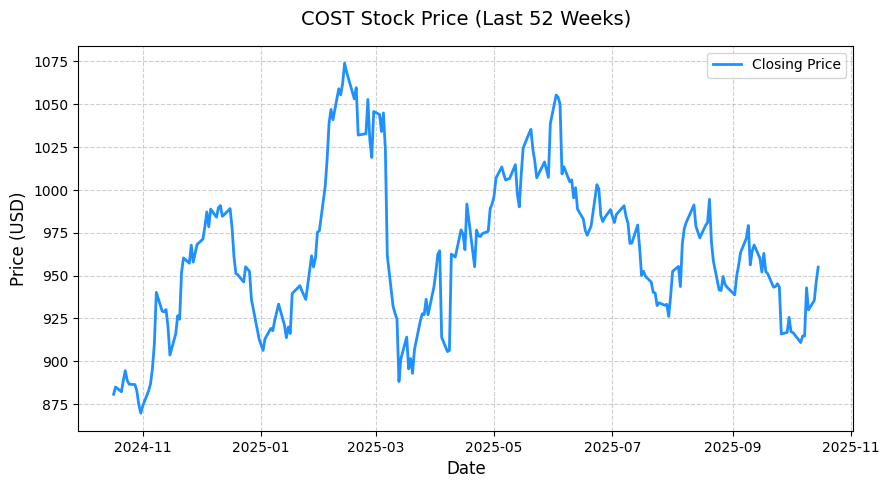

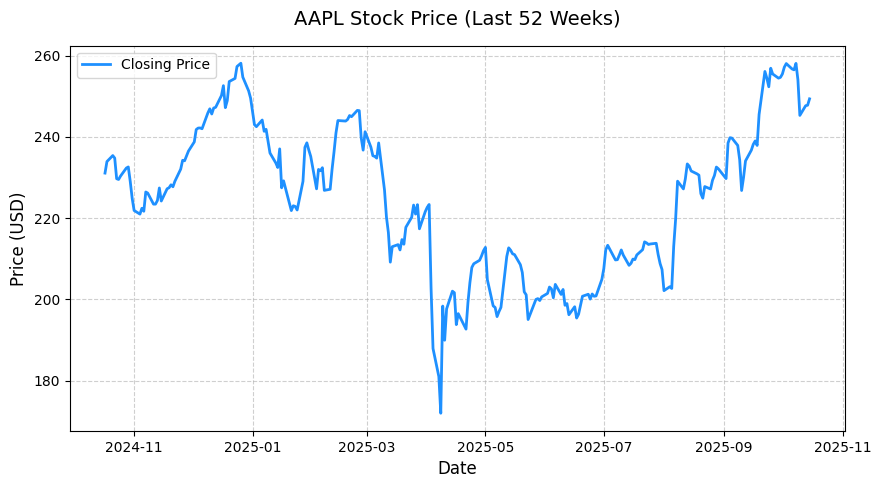